In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
%pwd

'/home/ardigen/Documents/bertrand/bertrand/notebooks'

In [3]:
bertrand_results_mask = pd.read_csv('../../results/bertrand_with_outliers_filtering.csv')
bertrand_results_nomask = pd.read_csv('../../results/bertrand_wo_outliers_filtering.csv')

In [4]:
bertrand_results_mask['mask'] = True
bertrand_results_nomask['mask'] = False

In [5]:
bertrand_results_df = pd.concat([bertrand_results_mask, bertrand_results_nomask])

In [6]:
bertrand_results_df.head()

,rocs,n,peptide,cv_seed,dataset,subset,mask
0,0.584770,48,CTELKLSDY,42,dataset_42,test,True
1,0.714855,30,FLRGRAYGL,42,dataset_42,test,True
2,0.544338,266,FRCPRRFCF,42,dataset_42,test,True
3,0.618622,28,GLNKIVRMY,42,dataset_42,test,True
4,0.610269,66,GPGHKARVL,42,dataset_42,test,True


In [7]:
nettcr_results_df = pd.read_csv('../../results/nettcr.csv')
ergo_results_df = pd.read_csv('../../results/ergo.csv')

In [8]:
nettcr_results_df = nettcr_results_df.rename(columns={'ds_seed': 'dataset', 'set': 'subset' })
nettcr_results_df.dataset = 'dataset_' + nettcr_results_df.dataset.astype(str)
nettcr_results_df.n = nettcr_results_df.n.astype(int)

In [9]:
ergo_results_df = ergo_results_df.rename(columns={'ds_seed': 'dataset', 'set': 'subset' })
ergo_results_df.dataset = 'dataset_' + ergo_results_df.dataset.astype(str)
ergo_results_df.n = ergo_results_df.n.astype(int)

In [10]:
ergo_results_df.head()

,rocs,n,peptide,cv_seed,dataset,mask,subset
0,0.471301,244,CTELKLSDY,42,dataset_42,False,test
1,0.526488,886,EIYKRWII,42,dataset_42,False,test
2,0.590462,1330,FRCPRRFCF,42,dataset_42,False,test
3,0.600000,12,GEIYKRWII,42,dataset_42,False,test
4,0.656535,783,IPSINVHHY,42,dataset_42,False,test


In [11]:
for dataset in ['dataset_42', 'dataset_43', 'dataset_44']:
    for cv_seed in range(42, 63):
        for mask in [True, False]:
            for subset in ['test', 'cancer']:
                r1 = bertrand_results_df[
                    (bertrand_results_df.dataset == dataset) & 
                    (bertrand_results_df.cv_seed == cv_seed) & 
                    (bertrand_results_df['mask'] == mask)  & 
                    (bertrand_results_df['subset'] == subset)
                ]

                r2 = nettcr_results_df[
                    (nettcr_results_df.dataset == dataset) & 
                    (nettcr_results_df.cv_seed == cv_seed) & 
                    (nettcr_results_df['mask'] == mask)  & 
                    (nettcr_results_df['subset'] == subset)
                ]
                r3 = ergo_results_df[
                    (ergo_results_df.dataset == dataset) & 
                    (ergo_results_df.cv_seed == cv_seed) & 
                    (ergo_results_df['mask'] == mask)  & 
                    (ergo_results_df['subset'] == subset)
                ]
            if len(r1) != len(r2) or len(r1) != len(r3) or (np.unique(r1.peptide) != np.unique(r2.peptide)).all() or (np.unique(r1.peptide) != np.unique(r3.peptide)).all():
                raise Exception()

In [12]:
bertrand_results_df.loc[:, 'model'] = 'BERTrand' 
ergo_results_df.loc[:, 'model'] = 'ERGO' 
nettcr_results_df.loc[:, 'model'] = 'NetTCR2.0' 

In [13]:
results_df = pd.concat([bertrand_results_df, ergo_results_df, nettcr_results_df])

In [14]:
results_df.loc[:, 'subset'] = results_df['subset'].map({'test': 'Cross validation test set', 'cancer': 'Independent cancer set'})
results_df.loc[:, 'mask'] = results_df['mask'].map({False: 'Basic filtering', True: 'Easy negatives filtering'})

In [15]:
results_df.head(2)

,rocs,n,peptide,cv_seed,dataset,subset,mask,model
0,0.584770,48,CTELKLSDY,42,dataset_42,Cross validation test set,Easy negatives filtering,BERTrand
1,0.714855,30,FLRGRAYGL,42,dataset_42,Cross validation test set,Easy negatives filtering,BERTrand


In [16]:
results_df[results_df.n >= 5].groupby(['model', 'subset', 'mask']).rocs.agg('mean').unstack()

mask                                 Basic filtering  Easy negatives filtering
model     subset                                                              
BERTrand  Cross validation test set         0.681255                  0.625300
          Independent cancer set            0.719264                  0.664397
ERGO      Cross validation test set         0.654468                  0.577079
          Independent cancer set            0.668119                  0.586522
NetTCR2.0 Cross validation test set         0.629726                  0.569234
          Independent cancer set            0.645300                  0.578768

In [17]:
results_df_agg = results_df[results_df.n >= 5].groupby(['model', 
                                                        'subset',
                                                        'mask',
                                                        'dataset', 
                                                        'cv_seed']).rocs.agg(['mean', 'std']).reset_index()

In [18]:
results_df_agg.rename(columns={'mean': 'roc', 'std': 'roc_std'}, inplace=True)

In [19]:
# Data for cancer peptides plot
pep_res_df = bertrand_results_df[(bertrand_results_df['mask'] == True) &
                                 (bertrand_results_df['subset'] == 'cancer') & 
                                 (bertrand_results_df['n'] >= 5)
                                ].copy()
# Extract info about peptide clusters
df_1 = pd.read_csv('../../results/negative_decoys/datasets/dataset_42.csv.gz')
pep_to_cluster = df_1.groupby('peptide_seq').peptide_cluster.agg('first')
pep_res_df.loc[:, 'peptide_cluster'] = pep_to_cluster.loc[pep_res_df.peptide].values
n_by_cluster = pep_res_df.groupby('peptide').agg('first').groupby('peptide_cluster').n.sum()
pep_res_df.loc[:, 'peptide_cluster_n'] = n_by_cluster.loc[pep_res_df.peptide_cluster].values
pep_res_df.sort_values(['peptide_cluster_n', 'n'], ascending=[False, False], inplace=True)
pep_res_df.loc[:, 'Peptide'] = pep_res_df.peptide + ' (n=' + pep_res_df.n.astype(str) + ')'# + pep_res_df.peptide_cluster
pep_res_df.loc[:, 'AUROC'] = pep_res_df.rocs
peptide_order = pep_res_df.groupby('peptide').n.agg('first').sort_values(ascending=False)

N = 30
pep_res_df_head = pep_res_df[pep_res_df.peptide.isin(peptide_order.head(N).index)]

pep_res_mean = pep_res_df_head.groupby('Peptide', sort=False).agg({
    'AUROC': ['mean', 'std'],
    'peptide_cluster': 'first',
})

cancer_means = pep_res_mean.AUROC['mean']
cancer_stds = pep_res_mean.AUROC['std']
total_mean_std = pep_res_df.groupby(['cv_seed', 'dataset']).rocs.agg(['mean', 'std']).mean(axis=0)
cancer_means.loc['TOTAL'] = total_mean_std['mean']
cancer_stds.loc['TOTAL'] = total_mean_std['std']

<ipython-input-19-7b9591cbdc90>:7: DtypeWarning: Columns (1,2,3,4,6,7,8,9,10,12,13,14,16,17,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,40,42,43,44,45,46,47,48,49,51,58) have mixed types. Specify dtype option on import or set low_memory=False.
  df_1 = pd.read_csv('../../results/negative_decoys/datasets/dataset_42.csv.gz')
<ipython-input-19-7b9591cbdc90>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cancer_means.loc['TOTAL'] = total_mean_std['mean']
<ipython-input-19-7b9591cbdc90>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cancer_stds.loc['TOTAL'] = total_mean_std['std']


In [20]:
def plot_peptides(ax):
    """
    plots per-peptide vertical barplot - subplot E
    """
    ax.barh(cancer_means.index[-1], cancer_means.iloc[-1],  xerr=cancer_stds.iloc[-1], capsize=5, color='#53A40D',height=0.75)
    ax.barh(cancer_means.index[::-1][1:], cancer_means[::-1][1:],  xerr=cancer_stds[::-1][1:], capsize=3, color='#1F77B4', height=0.75)
    ax.vlines(0.5, -1, N+1, color='red', linestyle='--')
    ax.set_xlim(0.2, 1.0)

In [21]:
def plot_benchmarks(x, y, yerr, **kwargs):
    """
    plots 1 barplot - subplots A, B, C, D
    """
    ax = plt.gca()
    data = kwargs.pop("data")
    kwargs.pop('color')
    sns.barplot(data=data, x=x, y=y, ax=ax, capsize=0.1, ci='sd', **kwargs,
                order=['NetTCR2.0', 'ERGO', 'BERTrand'], 
                palette=['#EF553B', '#1F77B4', '#53A40D'])
    auroc_mean = data.groupby('model')[y].agg('mean')
    auroc_mean = auroc_mean.loc[['NetTCR2.0', 'ERGO', 'BERTrand']]
    for i, roc in enumerate(auroc_mean):
        text  = '%.2f' % roc
        ax.text(i, 0.3,  text, color='white', fontweight='bold', fontsize=15, ha='center', va='center')
    ax.hlines(0.5, -0.5, 2.5, color='red', linestyle='--')

In [22]:
results_df_agg.sample(2)

,model,subset,mask,dataset,cv_seed,roc,roc_std
306,ERGO,Cross validation test set,Basic filtering,dataset_44,54,0.614065,0.193087
428,ERGO,Independent cancer set,Basic filtering,dataset_44,50,0.658553,0.291106


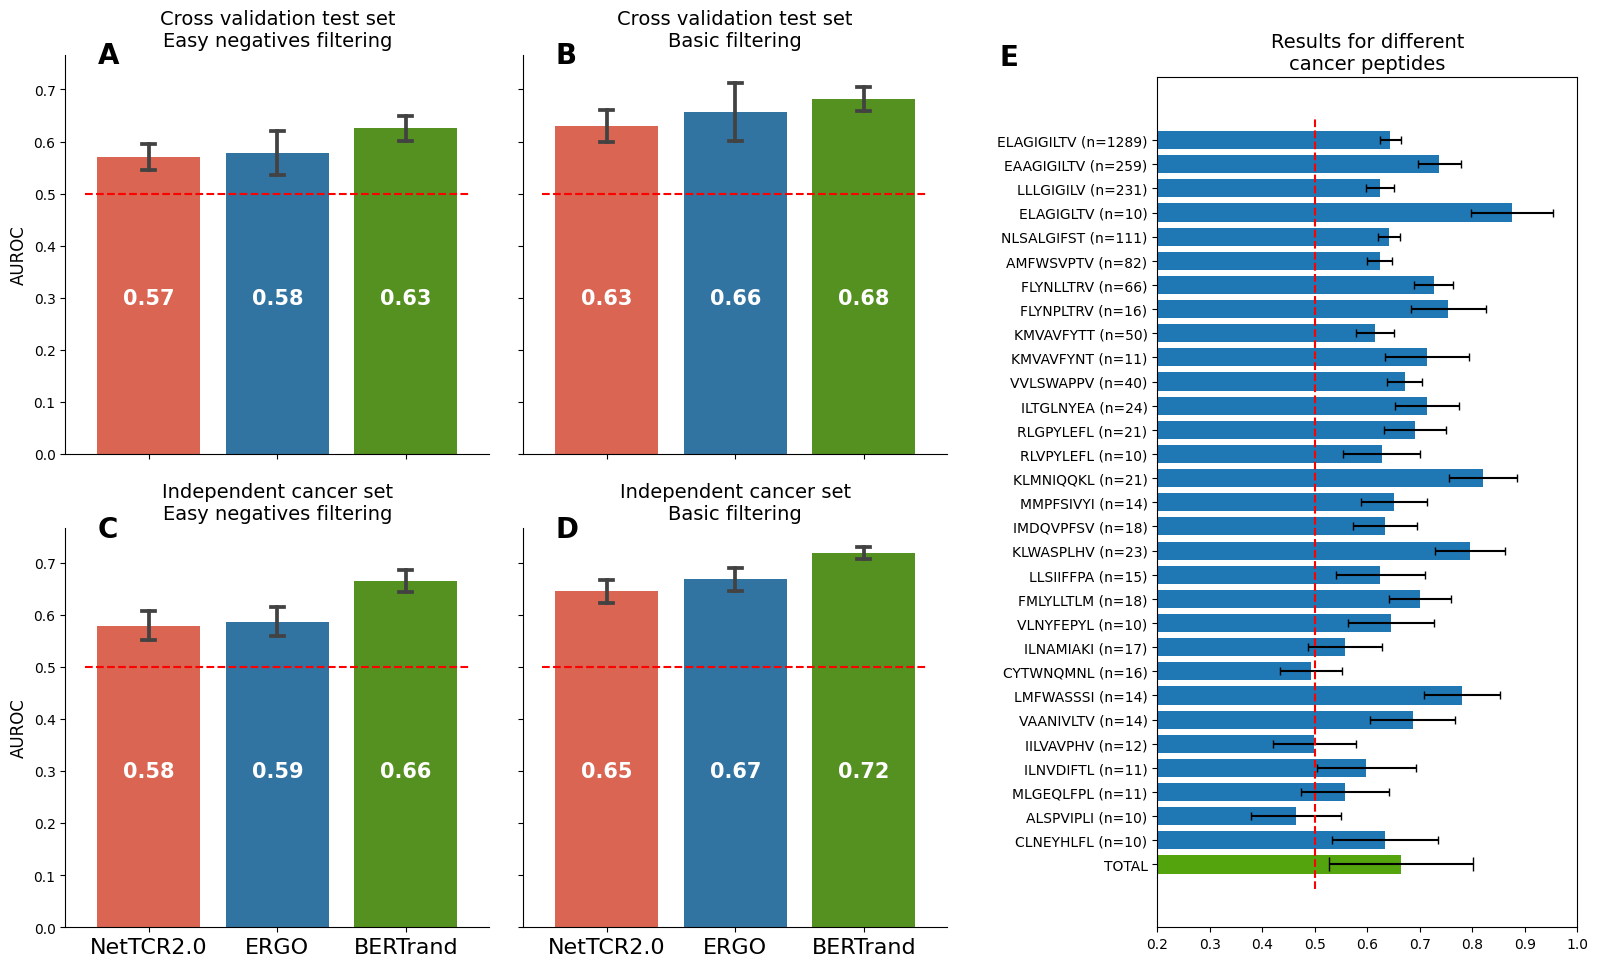

In [30]:

        

g = sns.FacetGrid(results_df_agg, col="mask", row="subset", col_order=['Easy negatives filtering', 'Basic filtering'], )
g.map_dataframe(plot_benchmarks, "model", "roc", "roc_std")

g.set_titles(template="{row_name}\n{col_name}", size=14) # {row_name}\n{col_name}
[plt.setp(ax.get_xticklabels(), rotation=0, fontsize=16) for ax in g.axes.flat]
[ax.set_xlabel('') for ax in g.axes.flat]
g.axes[0, 0].set_ylabel('AUROC', fontsize=12)
g.axes[1, 0].set_ylabel('AUROC', fontsize=12)



for ax, letter in zip(g.axes.flat, ["A","B", "C","D"]):
    ax.text(-0.4, 0.75 ,letter, fontweight="bold", fontsize=20)


g.fig.subplots_adjust(bottom=0.07, left=0.07, right=0.7)



# g.figure.subplots_adjust()
ax = g.fig.add_axes([0.85, 0.07, 0.3, 0.85], label='axis1')
ax.text(-0.1, 33.1, "E",fontweight="bold", fontsize=20)

plot_peptides(ax)
ax.set_title('Results for different\ncancer peptides', fontsize=14)
g.fig.set_size_inches(14, 10)
# from matplotlib.transforms import Bbox
# g.figure.savefig('comparison.png', bbox_inches="tight")

plt.savefig('comparison.eps', format='eps', bbox_inches="tight")
plt.show()